# Density profiles

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from multirods_gpe.style import set_base_style
from multirods_gpe import MultiRods
from multirods_gpe.bloch import ideal_eigen_states, GPEBlochState
from multirods_gpe.spectrum import IdealSpectrum, GPESpectrum
from multirods_gpe.model import ER

In [3]:
from itertools import cycle, islice
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

## EDIT: Paths and non-standard imports >>>

In [4]:
import os, sys
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.insert(0, proj_dir)

### <<< End of paths and non-standard import
----

## Delta lattice, $V_0 b = P_0 E_R a$

In [17]:
p0, r = 1 * ER, 0.05
v0 = p0 / r

systems = []
gn0_array = array([0, 1, 5, 10]) * ER
# gn0_array = array([0, 0.5, 5, 10]) * ER
for gn0 in gn0_array:
    system = MultiRods(v0, r, gn0)
    system.context.partition_order = 8
    systems.append(system)
    print(system.lattice_mesh_spec)

((320, 16), 0.002976190476190476)
((320, 16), 0.002976190476190476)
((320, 16), 0.002976190476190476)
((320, 16), 0.002976190476190476)


### Calculating density.

In [18]:
from scipy.integrate import trapz

In [19]:
density_data = []
skip_ideal = False
macro_kz = 0
bloch_band = 1

initial_state = None
for ctr, system in enumerate(systems):
    
#     r = float(system.lattice_ratio)
    gn0 = system.interaction_strength
#     print(ctr, gn0 / ER)
    
    if ctr == 0:
        ideal_states = ideal_eigen_states(system, momentum=macro_kz, max_eigen_states=2)
        state = ideal_states.get(bloch_band)
        print(state.energy / ER)
    else:
#     else:
        state = GPEBlochState.from_state(initial_state, macro_kz, system=system)
        print(state.chemical_potential / ER)
    
    initial_state = state
        
#     print(state.energy / ER, trapz(absolute(state.wave_fn)**2, 
#                 x=system.domain_mesh))
    
        
#     state = GPEBlochState.from_state(state, macro_kz)
#     else:
#         state = ideal_state

    density_data.append([system, state])

C:\Users\oarodriguez\Academic Projects\MultiRodsGPE\multirods_gpe\bloch.py:325: ComplexWarning: Casting complex values to real discards the imaginary part
  funcs_mesh = p_fn_mesh.astype(np.float64), q_fn_mesh


0.532588978826
1.64557393799
5.79176363722
10.8461829614


In [20]:
DASHES = [
    (5, 0.01),                  # "Solid"
    (5, 5/4),                   # Dash small-space
    (5, 5/4, 5/4, 5/4),         # Dash-dot
    (5/4, 5/4),                 #  Dot
    (5, 5/4, 5/2, 5/4, 5/2, 5/4),         # Dash, small-dash
    (2, 1, 1, 1),    # Dot-dash
    (4, 1, 1, 1),   # Long dash - dot
    (4, 1, 2, 1),   # Long dash - dot
    (6, 1)
]


C:\Users\oarodriguez\Academic Projects\PhDCode\reports\figures\n1z-gs_v0-20_r-0-dot-05.pdf


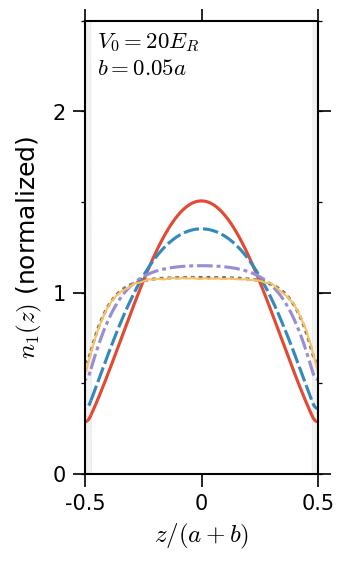

In [22]:
# Physical parameters
macro_kz = 0
bloch_band = 1

# %% Figure base style
set_base_style()

figure(figsize=(2, 4))

ax = gca()

rcParams['legend.fontsize'] = 8

dashes = cycle(DASHES)

# Switches
subplot_left = True
if subplot_left:
    add_legend = False
else:
    add_legend = True

 # Some dimensions
y_max = 2.5

plt_fmt = r'$V_0 = {:5G} E_R$' + "\n" + '$b = {:.3G} a$'
plt_lb = plt_fmt.format(v0 / ER, r)
ax.text(-0.45, 0.88 * y_max, plt_lb, fontsize=11)

skip_ideal = False
for ctr, data in enumerate(density_data):
    
    system, state = data
    r = float(system.lattice_ratio)
    gn0 = system.interaction_strength
    
    dash = next(dashes)
    
    if system.interaction_strength:
        phi_k = absolute(state.wave_fn) ** 2
        plb = r'${:5G}$'.format(gn0 / ER)
    else:
        phi_k = absolute(state.wave_fn) ** 2
        plb = None

    z = system.domain_mesh
    vz_unit = system.potential(z) / v0
    za = 1 / (1 + r) / 2

    line, = ax.plot(z - za, phi_k, label=plb, dashes=dash)
    ax.plot(z - 1 -  za, phi_k, color=line.get_color(), dashes=dash)
    
ax.fill_between(z - za, vz_unit * 2.5, alpha=0.25, 
                  color='#cccccc')
ax.fill_between(z - 1 - za, vz_unit * 2.5, alpha=0.25,
            color='#cccccc')

add_legend = False
if add_legend:
    legend_ = ax.legend(bbox_to_anchor=(0.59, 0.715))
    leg_title = legend_.get_title()
    legend_.set_title(r'$gn_0 / E_R$', prop=dict(size=9))
    leg_frame = legend_.get_frame()
    setp(leg_frame, fc='#FFFFFF', alpha=0.5)
    

y_loc = MultipleLocator(1.0)
y_fmt = FormatStrFormatter('%d')
y_min_loc = MultipleLocator(0.5)

ax.yaxis.set_major_locator(y_loc)
ax.yaxis.set_major_formatter(y_fmt)
ax.yaxis.set_minor_locator(y_min_loc)

# %%
sd_path = os.path.join(os.getcwd(), 'data', 'seaman-density-data-pra-71-033622-2005.txt')
seaman_data = loadtxt(sd_path)

z_sd, phi_sd = seaman_data.T
line, = ax.plot(z_sd - 0.5, phi_sd, lw=1)

ax.set_xlabel(r'$z/(a + b)$')
ax.set_ylabel(r'$n_1(z)$ (normalized)')

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(0, y_max)

# Some manual labelling
ax.set_xticks([-0.5, 0, .5])
ax.set_xticklabels([-.5, '0', .5])

fn_fmt = r'n1z-gs_v0-{:.5G}_r-{:.5G}'
file_name = fn_fmt.format(v0 / ER, r)

full_path = os.path.join(proj_dir,
                         'reports', 'figures',
                         '{:s}.pdf'.format(file_name.replace('.', '-dot-')))

savefig(full_path)

print(full_path)

### Ideal spectrum

In [9]:
states_per_zone = 2 ** 5
ideal_spec = IdealSpectrum(system, states_per_zone)

C:\Users\oarodriguez\Academic Projects\MultiRodsGPE\multirods_gpe\bloch.py:325: ComplexWarning: Casting complex values to real discards the imaginary part
  funcs_mesh = p_fn_mesh.astype(np.float64), q_fn_mesh


(0, 11.739060418940863)

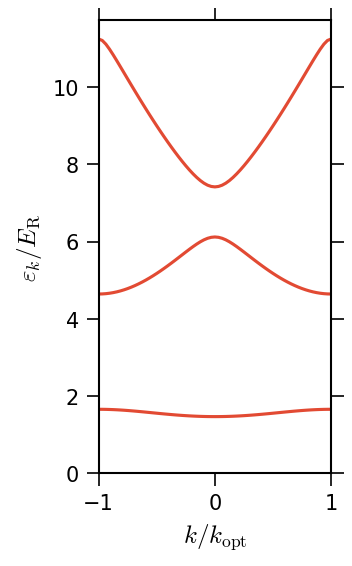

In [29]:
set_base_style()

figure(figsize=(2, 4))

lc_ = None
for bloch_band in [1, 2, 3]:
    ideal_band = ideal_spec.get(bloch_band)   
    line, = plot(ideal_band.momentum / pi, 
                 ideal_band.energy / ER, 
                 color=lc_)
    lc_ = line.get_color()
    
xlabel(r'$k / k_{\mathrm{opt}}$')
ylabel(r'$\varepsilon_k / E_{\mathrm{R}}$')

xlim(-1, 1)
ylim(ymin=0)